In [1]:
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns

通过一次实验，可以看出，如果网格能够覆盖整个价格波动的区间，是能够高抛低吸的
do experiment on differnt patterns 

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 1. Data cleaning

In [3]:
# retreive the price of ETHUSDT
# read data
data_raw = pd.read_csv("ETHUSDT.csv")
data_raw.head()

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,1640736000000,3792.75,3821.02,3785.00,3818.50,3840.8369,1640736899999,1.459777e+07,8393,2269.6368,8.625008e+06,0
1,1640736900000,3818.51,3820.50,3806.84,3809.18,2002.2730,1640737799999,7.636232e+06,4830,875.4385,3.338980e+06,0
2,1640737800000,3809.18,3809.18,3792.04,3800.29,2252.7469,1640738699999,8.557957e+06,6017,1173.1508,4.456601e+06,0
3,1640738700000,3800.29,3820.00,3799.36,3818.07,2199.4497,1640739599999,8.386157e+06,5231,1156.4399,4.408653e+06,0
4,1640739600000,3818.06,3826.85,3811.57,3826.00,2656.7679,1640740499999,1.014970e+07,5554,1473.5940,5.630382e+06,0


In [4]:
# Drop columns. the dataframe "data" is used as an order history book
data = data_raw[['close_time','close']]

#calculate market return
data['market_return'] = data.close.pct_change(1)
data.head()

,close_time,close,market_return
0,1640736899999,3818.50,NaN
1,1640737799999,3809.18,-0.002441
2,1640738699999,3800.29,-0.002334
3,1640739599999,3818.07,0.004679
4,1640740499999,3826.00,0.002077


In [5]:
# Slice data into training set and test set
training_set = data.iloc[:200,]
#test_set = data[-100:,]

# 2. EDA

EDA stugies the volatility of the price. And help to decide the minimum grid interval.

In [6]:
print('Min market return: ', data.market_return.min())
print('Max market return: ', data.market_return.max())

Min market return:  -0.017890434243008846
Max market return:  0.014769447604907171


Text(0, 0.5, 'Density')

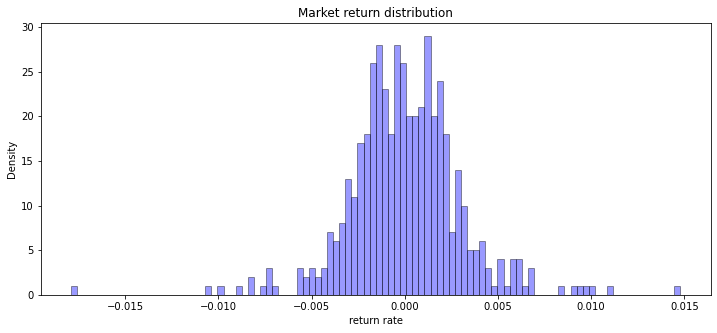

In [7]:
plt.figure(figsize=(12,5))
# matplotlib histogram
"""plt.hist(data['market_return'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))"""

# seaborn histogram
sns.distplot(data['market_return'], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Market return distribution')
plt.xlabel('return rate')
plt.ylabel('Density')

There are two types of the grids strategy: arithmatric and geomatric. (https://quantpedia.com/a-primer-on-grid-trading-strategy/).Form the hist grame above, the volatility of the price falls whitin (-0.5%, +0.5%). Geometric grid is more suitable for larger price range(higher than commission). So we use arithmatric method.

# 3. Initialization

Quantpedia warned how grid trading can create an illusion of profit if  not considering closing position in the end of the trading. Therefore, we will evaluate the profit on the total value of the portfolio.
The measurement of profit report will be illustrated in both Market-to-Market and a period report.

In [8]:
# Initialize the parameters. set number of grids as a hyperparameter and tune
initial_position = 100   # You must hold some coins to start the strategy. 
capital = 1000000        # What is the maximum capital that can be invested?
trading_commission = 0.001   #Pionex 0.05%, Binance: 0.1% or 0.075% (BNB)
num_grid = 15

# Assume the upper limit and lower limit are perfectly predicted, which means the grids captured all price movements
lower_price = data.close.max()
higher_price = data.close.min() 

In [9]:
#Create the grid
def create_grid(higher_price,lower_price,num_grid):
    mid = (higher_price + lower_price)/2
    interval = (higher_price - lower_price)/num_grid
    a = num_grid/2
    grid = pd.DataFrame()
    grid['grid_level']  = [x for x in np.arange(             #you have to write this way to create a list not a range
                    mid - interval * a - interval/2,
                    mid + interval * a,
                    interval)]

    # 1 is long, -1 is short
    grid['signal'] = 1
    grid['signal'].iloc[0:int((num_grid + 1)/2)] = -1
    return grid

grid = create_grid(higher_price,lower_price,num_grid)

In [10]:
grid

,grid_level,signal
0,3845.868667,-1
1,3831.371333,-1
2,3816.874000,-1
3,3802.376667,-1
4,3787.879333,-1
5,3773.382000,-1
6,3758.884667,-1
7,3744.387333,-1
8,3729.890000,1
9,3715.392667,1


In [11]:
# Place oders on each of the grid level.

def start_trading(training_set,initial_position, capital, grid,trading_commission):
    
    # set up  
    training_set['Portfolio_value'] = 0
    training_set['Portfolio_value'][0] = initial_position * training_set.close[0] + capital
    training_set['position'] =0

    # Define the function that finds the two closest grid level, given the current price
    def find_grids(grid, pt):
        grid['distance'] = abs(grid.grid_level - pt)
        smallest_distance = grid['distance'].nsmallest(2)
        nearest_grid_level = grid.iloc[smallest_distance.index]
        return nearest_grid_level
    
    for i in range(1,len(training_set)):
        nearest_grid_level = find_grids(grid, training_set.close[i-1])
        pt = training_set['close'][i]
        upper_grid= max(nearest_grid_level['grid_level'])
        lower_grid = min(nearest_grid_level['grid_level'])
        
        if pt > upper_grid:    
            #if the price traverses the upper limit, then place an order on that price level
            training_set['position'][i] = grid[grid['grid_level'] == upper_grid]['signal']
        elif pt < lower_grid:
            training_set['position'][i] = grid[grid['grid_level'] == lower_grid]['signal']
    
    # Calculate accumulate position   
    training_set['transaction'] = training_set['position'] * training_set['close'] 
    training_set['transaction'][0] = capital
    training_set['balance'] = np.cumsum(training_set.transaction) 
    training_set['accumulate_position'] = np.cumsum(training_set.position) + initial_position
    training_set['Portfolio_value'] = training_set['accumulate_position']* training_set['close'] + training_set['balance']
    training_set['strategy_return_MTM'] = training_set.Portfolio_value.pct_change(1)
    #training_set["strategy_return_MTM"][0:3]=[0,0,0]
    training_set["accum_market_return"] = np.cumsum(training_set.market_return) 
    training_set['accum_strategy_return_MTM'] = np.cumsum(training_set.strategy_return_MTM)
    
    """
    training_set['reverse_accum_return'] =  np.sum(training_set.market_return) - training_set["accum_market_return"]
    training_set['strategy_return_each_decision'] = training_set["position"] * (training_set["reverse_accum_return"] - trading_commission)
    """
    
    """print("Number of buy orders placed:",training_set.query('position == 1').shape[0])
    print("Number of sell orders placed:",training_set.query('position == -1').shape[0])"""
    
    return training_set

# 3. 

In [12]:
grid = create_grid(higher_price,lower_price,num_grid)
training_set=start_trading(training_set,initial_position, capital, grid,trading_commission)

In [13]:
training_set.head(10)

,close_time,close,market_return,Portfolio_value,position,transaction,balance,accumulate_position,strategy_return_MTM,accum_market_return,accum_strategy_return_MTM
0,1640736899999,3818.50,NaN,1381850.00,0,1000000.00,1000000.00,100,NaN,NaN,NaN
1,1640737799999,3809.18,-0.002441,1373299.64,-1,-3809.18,996190.82,99,-0.006188,-0.002441,-0.006188
2,1640738699999,3800.29,-0.002334,1364818.95,-1,-3800.29,992390.53,98,-0.006175,-0.004775,-0.012363
3,1640739599999,3818.07,0.004679,1358925.25,-1,-3818.07,988572.46,97,-0.004318,-0.000096,-0.016681
4,1640740499999,3826.00,0.002077,1359694.46,0,0.00,988572.46,97,0.000566,0.001981,-0.016115
5,1640741399999,3810.00,-0.004182,1350522.46,-1,-3810.00,984762.46,96,-0.006746,-0.002201,-0.022861
6,1640742299999,3805.65,-0.001142,1350104.86,0,0.00,984762.46,96,-0.000309,-0.003343,-0.023170
7,1640743199999,3801.37,-0.001125,1342091.24,-1,-3801.37,980961.09,95,-0.005936,-0.004467,-0.029106
8,1640744099999,3813.03,0.003067,1335572.88,-1,-3813.03,977148.06,94,-0.004857,-0.001400,-0.033963
9,1640744999999,3812.11,-0.000241,1335486.40,0,0.00,977148.06,94,-0.000065,-0.001641,-0.034027


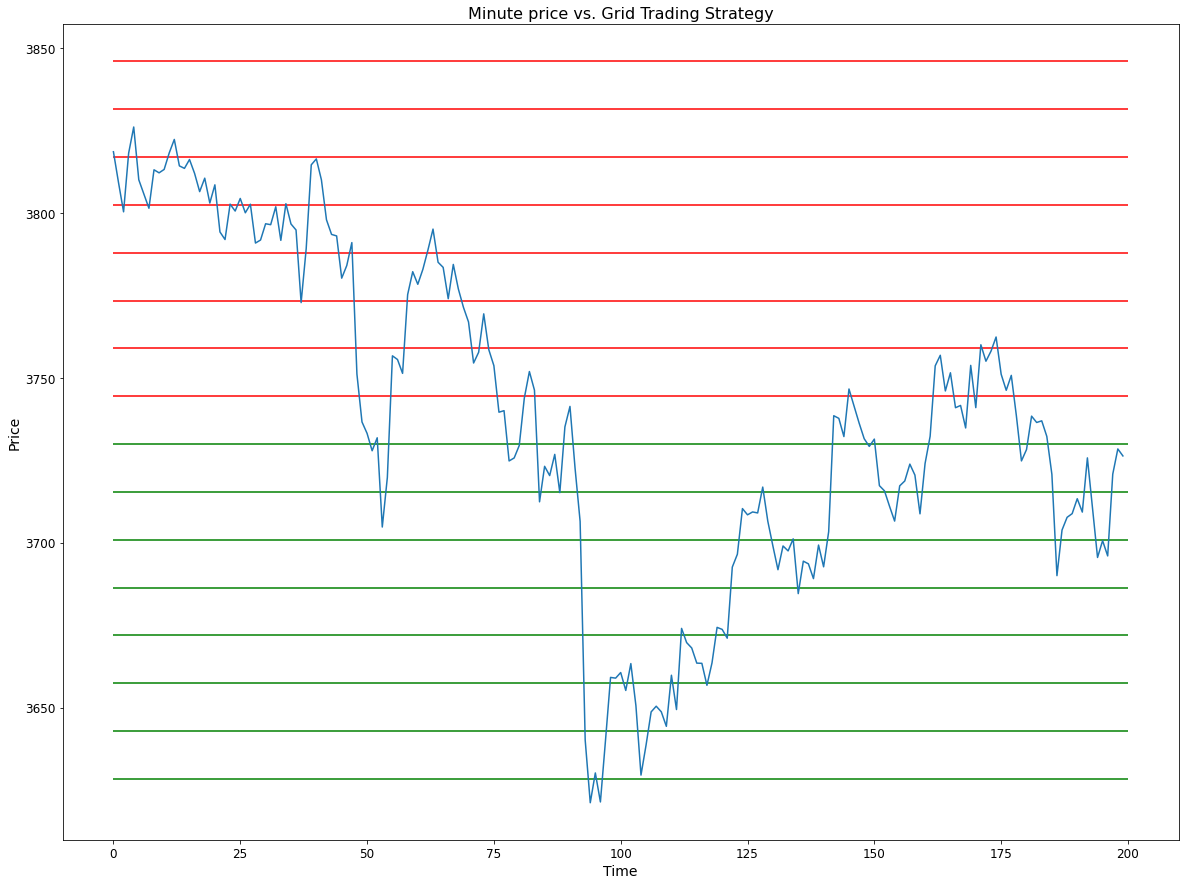

In [14]:
# Define plot of the Griding Strategy

def plot_strategy(close_price, grid,training_set):
    # Plot cumulative returns
    plt.figure(figsize=(20,15))

    # Plot close price
    plt.plot(close_price)

    # Plot grids
    plt.hlines(grid.query('signal == 1').grid_level, xmin = 0, xmax= len(training_set), color='green', linestyle='-')
    plt.hlines(grid.query('signal == -1').grid_level, xmin = 0, xmax= len(training_set), color='red', linestyle='-')

    # Define the label for the title of the figure
    plt.title('Minute price vs. Grid Trading Strategy', fontsize=16)

    # Define the labels for x-axis and y-axis
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Price', fontsize=14)

    # Define the tick size for x-axis and y-axis
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

plot_strategy(training_set['close'], grid, training_set)

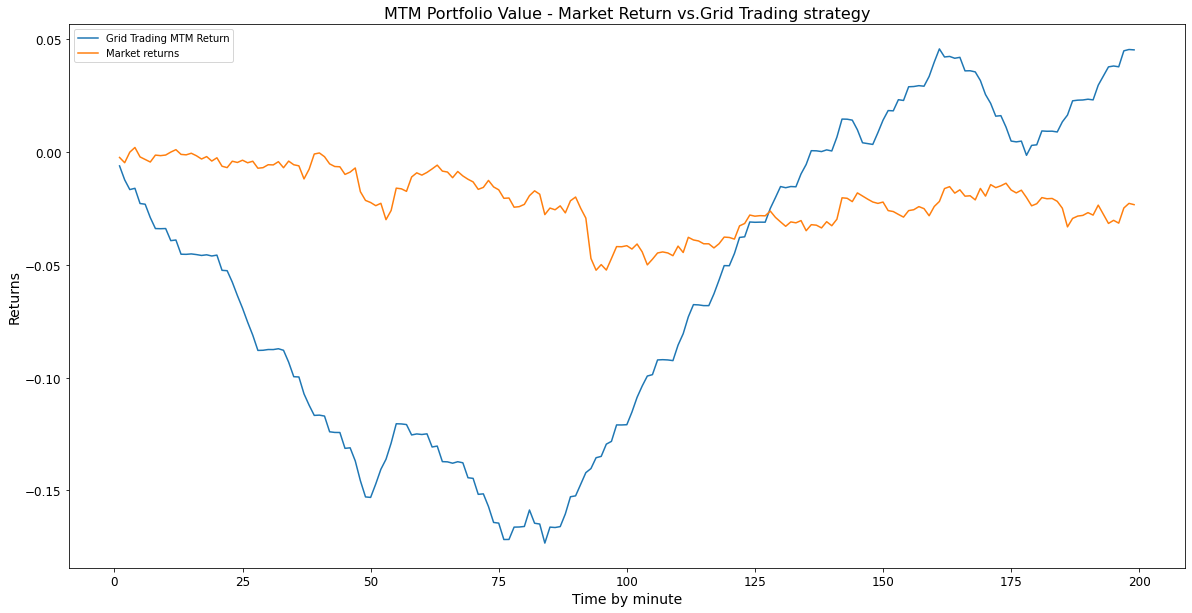

In [15]:
# Plot cumulative returns
plt.figure(figsize=(20,10))

plt.plot(training_set.accum_strategy_return_MTM, label = 'Grid Trading MTM Return')
plt.plot(training_set["accum_market_return"], label = 'Market returns')

# Define the label for the title of the figure
plt.title('MTM Portfolio Value - Market Return vs.Grid Trading strategy', fontsize=16)

# Define the labels for x-axis and y-axis
plt.xlabel('Time by minute', fontsize=14)
plt.ylabel('Returns', fontsize=14)
plt.legend()

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

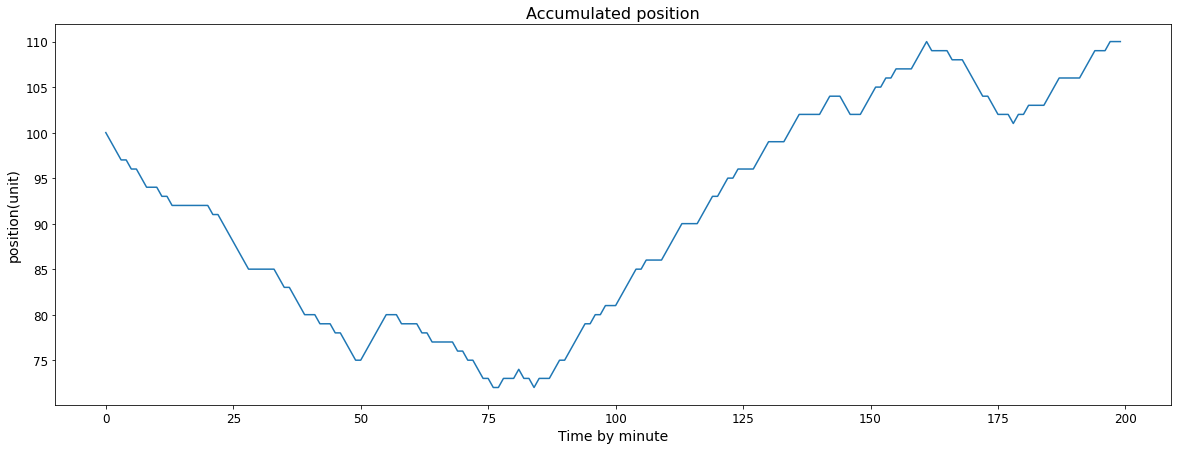

In [16]:
# Print position
plt.figure(figsize=(20,7))

plt.plot(training_set.accumulate_position, label = 'Accumulated position')

# Define the label for the title of the figure
plt.title('Accumulated position', fontsize=16)

# Define the labels for x-axis and y-axis
plt.xlabel('Time by minute', fontsize=14)
plt.ylabel('position(unit)', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# Print all trading decisions
training_set.to_csv("griding trading order history.csv")

print('Strategy Decisions History')
# print(training_set.query('position == 1 | position==-1'))
print("Number of buy orders placed:",training_set.query('position == 1').shape[0])
print("Number of sell orders placed:",training_set.query('position == -1').shape[0])

## 6. Train model

In [20]:
report_df = pd.DataFrame(columns = ['number_of_grids','strategy_return'])

for i in range(0,15,1):
    num_grid = i*2+1
    grid =create_grid(higher_price,lower_price,num_grid)
    strategy_return = start_trading(training_set,initial_position, capital, grid,trading_commission)['accum_strategy_return_MTM'].iloc[-1]
    note = [num_grid,strategy_return]
    report_df.loc[i] = note


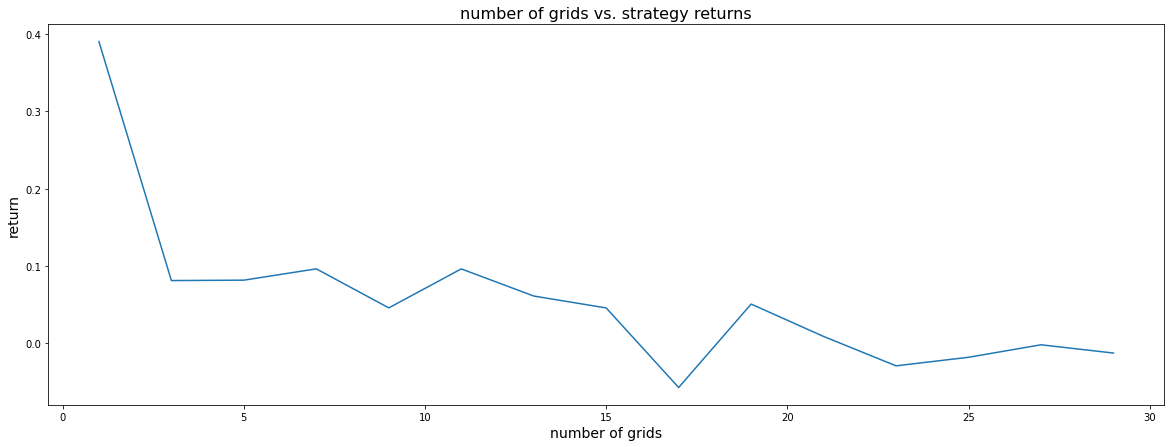

In [21]:
plt.figure(figsize=(20,7))

plt.plot(report_df['number_of_grids'],report_df['strategy_return'] )

# Define the label for the title of the figure
plt.title('number of grids vs. strategy returns', fontsize=16)

# Define the labels for x-axis and y-axis
plt.xlabel('number of grids', fontsize=14)
plt.ylabel('return', fontsize=14)

plt.show()